>Harsh Agarwal, haag00001@stud.uni-saarland.de, 7024725   
Zurana Mehrin Ruhi, zuru00001@stud.uni-saarland.de, 7023892

## Exercise 2.2 PCA for visualization purposes (3 points)

In this exercise you will perform visualization of [MNIST](http://yann.lecun.com/exdb/mnist/) dataset using PCA. The end result of this exercise should look like [Embedding Projector](https://projector.tensorflow.org/) (please select "Mnist with images" in the dropdown menu on the left of the page).  
Write your code in the respective cells. Of course, you can add additional cells or change their order, but please don't significantly change the structure of the notebook. You must use PyTorch tensors to perform all the calculations.  
For each question that requires written answer, please write it in a markdown cell.

In [1]:
%matplotlib inline
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from matplotlib import colors
import numpy as np
import tensorboard as tb
from torch.utils.tensorboard import SummaryWriter
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

#### Loading the data

In [2]:
# Download the dataset and save it to a local folder. You should use the train set.
mnist_dataset = torchvision.datasets.MNIST('data/', train=True, download=True)

X, Y = mnist_dataset.data, mnist_dataset.targets
print(X.shape)

X_flat = X.reshape(-1, 28*28).float()
print(X_flat.shape)

# We must make the data zero-centered before applying PCA
M = torch.mean(X_flat, axis=0)
X_flat = X_flat - M

torch.Size([60000, 28, 28])
torch.Size([60000, 784])


### 2.2.1. Perform PCA on the input data (1 point)

Calculate covariance matrix of the input data. Hint: You can use torch.matmul for matrix multiplication.

In [3]:
n = X_flat.size()
cov_mat = torch.matmul(X_flat.t(), X_flat) / (n[0]-1)
cov_mat

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Perform eigendecomposion of the covariance matrix. Hint: you can use torch.linalg.eig.

In [4]:
e_values, e_vectors = torch.linalg.eig(cov_mat)
# Considering only real part of eigen values and vectors
e_values = torch.view_as_real(e_values)[:,0]
e_vectors = torch.view_as_real(e_vectors)[:,:,0]


### 2.2.2 Analyzing the results of PCA (1 point)

Extract the first two principal components of the data, i.e. reduce the dimensionality of the dataset to 2. Plot the result. Different numbers must be represented as different colors on the scatter plot. You can use a randomly sampled portion of the data so that the plot doesn't get cluttered.   
Describe whether it's possible to differentiate the numbers in 2 dimensions. Are there any additional observations?

In [5]:
sorted_e_values, indices = torch.sort(e_values, dim=0, descending=True)
sorted_e_vectors = e_vectors[indices.squeeze()]

In [6]:
e_vector_subset = sorted_e_vectors[:,0:2]
X_reduced = torch.mm(e_vector_subset.t() , X_flat.t()).t()

num_samples = 10000
random_samples = random.sample(range(0, X_reduced.shape[0]), num_samples)

x = X_reduced[:, 0][random_samples]
y = X_reduced[:, 1][random_samples]
z = np.asarray(Y)[random_samples]

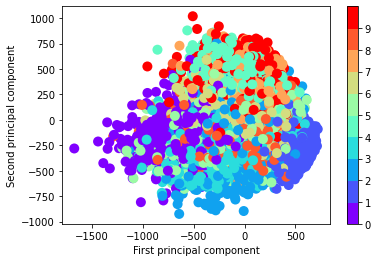

In [7]:
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

cmap = plt.cm.rainbow
norm = colors.BoundaryNorm(np.arange(0, 11, 1), cmap.N)

plt.scatter(x, y, c=z, cmap=cmap, norm=norm, s=100, edgecolor='none')
plt.colorbar(ticks=np.arange(10))

plt.show()

>Some numbers (like 0 and 1) are easily distinguishable even with just 2 dimensional data.
Whereas some other numbers like 5, 6, 7 are very hard to distinguish with just 2 dimensions. 

Plot the graph of cumulative explained variance vs number of components. You might also want to make an additional plot for the first N components. How many components should we use to describe the data? Motivate your answer.

In [8]:
e_values_total = torch.sum(e_values)
explained_variance = (100 * sorted_e_values) / e_values_total
cum_explained_variance = torch.cumsum(explained_variance, dim=0)

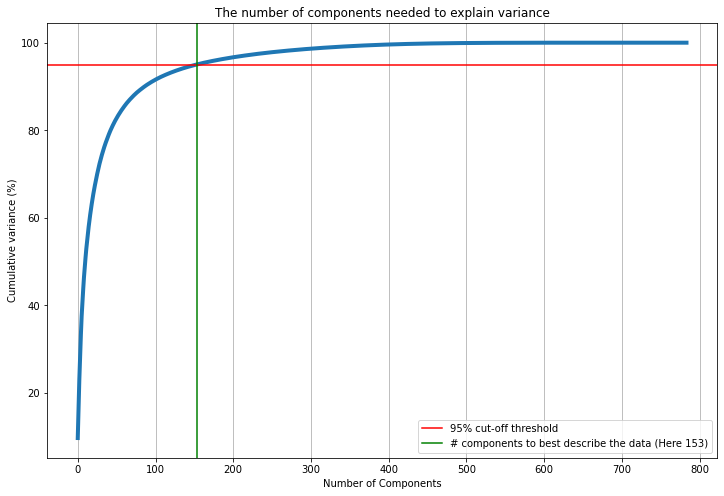

In [9]:
#plotting for  N number components 

N = 784 

plt.rcParams["figure.figsize"] = (12, 8)

fig, ax = plt.subplots()

# per_var_ex = pca.explained_variance_/np.sum(pca.explained_variance_)
y = cum_explained_variance

plt.plot(cum_explained_variance, linewidth = 4)

plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=95, color='r', linestyle='-', label='95% cut-off threshold')
plt.axvline(x=np.where(y>95)[0][0], color='g', linestyle='-', label="# components to best describe the data (Here {})".format(str(np.where(y>95)[0][0])))

ax.grid(axis='x')
plt.legend()
plt.show()

>#### Therefore, as we see above: To get 95% of variance explained we need 153 principal components.

### 2.2.3 Visualizing the data in 3 dimensions (1 point)

Reduce the dimensionality of the dataset to 3. Using Tensorboard visualize the resultant data in 3 dimensions. You should get the result similar to the [Embedding Projector](https://projector.tensorflow.org/) project (actually, they use the same Tensorboard package, so the result might be even exactly the same). You can use differently colored points instead of the digit pictures.

Analyze the resultant plot.  
Is 3 dimensions considerably better than 2?  
Which digits stand out in 3D and which digits are difficult to differentiate in 3 dimensions?

In [10]:
e_vector_subset_3 = sorted_e_vectors[:,0:3]
X_reduced_3 = torch.mm(e_vector_subset_3.t() , X_flat.t()).t()

num_samples = 10000
random_samples = random.sample(range(0, X_reduced_3.shape[0]), num_samples)

x = X_reduced[:, 0][random_samples]
y = X_reduced[:, 1][random_samples]

a = X_reduced_3[:, 0][random_samples]
b = X_reduced_3[:, 1][random_samples]
c = X_reduced_3[:, 2][random_samples]
z = np.asarray(Y)[random_samples]
img = torch.tensor(np.stack((np.asarray(X)[random_samples], np.asarray(X)[random_samples], np.asarray(X)[random_samples]))).permute(1, 0, 2, 3)

In [11]:
vectors = (np.vstack((np.asarray(a), np.asarray(b), np.asarray(c)))).transpose()
metadata = z  # labels
writer = SummaryWriter()
writer.add_embedding(vectors, metadata=metadata, label_img=img)
writer.close()

> From the location where this file is run from
a folder named `runs` is created, which stores the tensorboard file. To open tensorboard use the command 

` tensorboard --logdir=runs`

>and then go to this link to visualise the 3-D visualization
>http://localhost:6006/#projector


>Yes, the 3D visualization is considerably better than 2D as many more digits are easily identifiable now. 
0, 1, 2, 3 are easily distinguishable
4, 9, 7 are still hard to identify

> Screenshot of the visualization is shown below

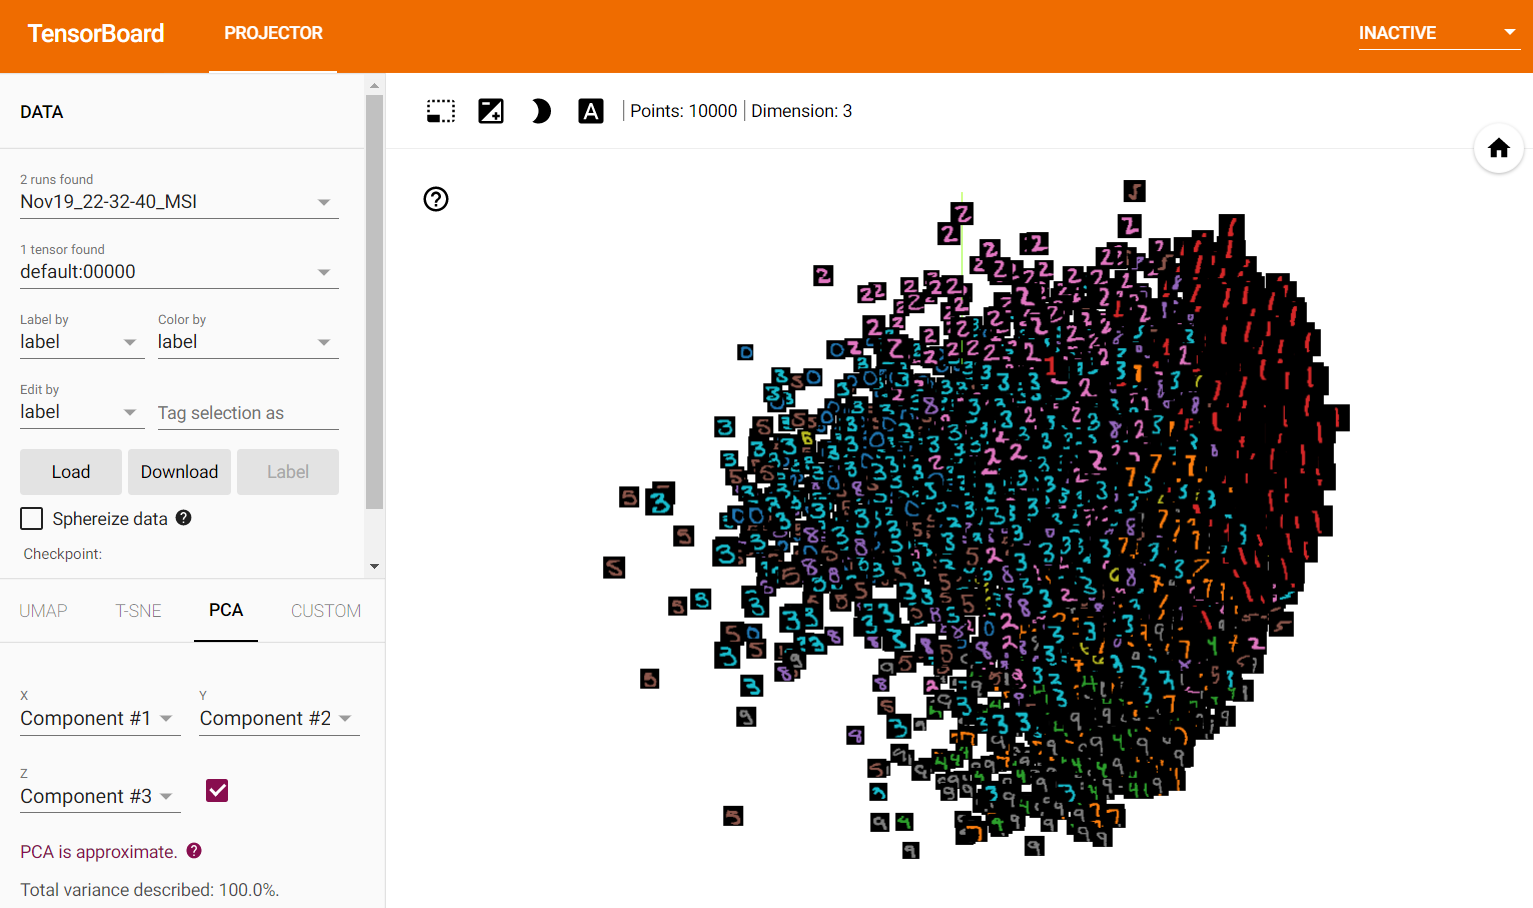

## Exercise 2.3. PCA vs Linear Regression (2 points)

### 2.3.1. Generating data (0.5 point)

Generate 2 dimensional linear data that follows the model assumed by linear regression (i.e. $y = \textbf{x}^T\textbf{w} + \epsilon$). For the purpose of this exercise you can use the following model: $y = 2x + 20 + \epsilon$, where $\epsilon \sim \mathcal{N}(0, 50)$. Generate 100 datapoints with $x$ varying anywhere from 0 to 200.  
Plot the resultant data.

In [12]:
# def data_generator(x):
#     ...
def data_generator(x):
    return 2*x + 20 + np.random.normal(0, 50, x.shape[0])

x = np.arange(0, 200)
y = data_generator(x)

num_samples = 100
sample_indices = np.random.choice(x.shape[0], num_samples)
X_data = x[sample_indices]
Y_data = y[sample_indices]

### 2.3.2. Performing PCA and Linear Regression (1.5 points)

Fit Linear Regression model for this data. Hint: for this purpose you can use sklearn.linear_model.LinearRegression.

In [13]:
reg = LinearRegression().fit(X_data.reshape(-1, 1), Y_data)
Y_pred = reg.predict(X_data.reshape(-1, 1))

Perform PCA on the generated data. This time you can use ready-to-use methods from packages, e.g. from sklearn.

In [14]:
pca = PCA(n_components=1)
XY = np.array([X_data, Y_data]).T
XY_pca = pca.fit_transform(XY)
XY_n = pca.inverse_transform(XY_pca)

Again plot the data, but this time include Linear Regression model line and the first principle component of PCA (plot it as a line of different color).

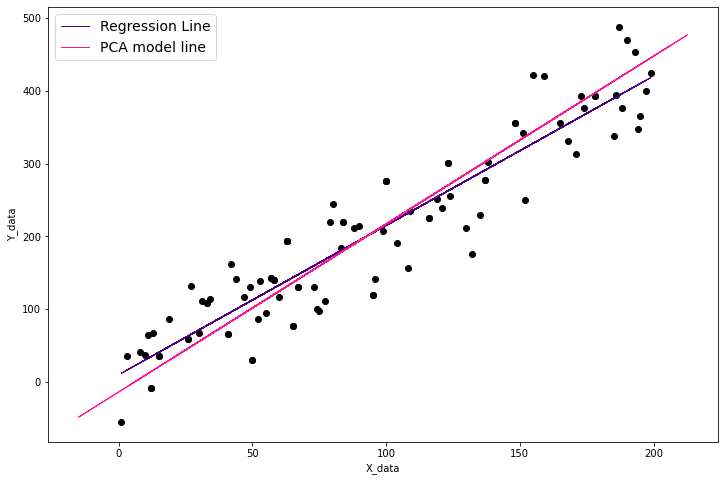

In [16]:
#Plot xy against xy_n. Note that we're simply passing x and y to the function since xy=x+y. 
plt.scatter(X_data, Y_data, color='black') 
plt.plot(X_data, Y_pred, color='indigo', linewidth=1) 
plt.plot(XY_n[:,0], XY_n[:,1], color='deeppink', linewidth=1) 
plt.axis('tight') 
plt.xlabel('X_data')
plt.ylabel('Y_data') 
plt.legend(['Regression Line', 'PCA model line'], loc='best', fontsize=14) 
plt.show()

Comment on the similarities and differences of two lines. What does PCA algorithm tries to minimize? What does Linear Regression algorithm tries to minimize? Write at least 4-5 sentences. Alternatively, provide graphical illustration on the same plot (in that case you can write less).

>PCA tries to minimize the orthogonal distance to the model line. Hence it equips orthogonal transformation to form the principal components
Regression tries to reduce the vertical distance of the points using least square method. Linear regression finds a straight line that best fits the data, depending on the data relationships